In [1]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
print(torch.__version__)
from torch import nn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import os
import warnings
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
import noisereduce as nr
import malaya_speech
from malaya_speech import Pipeline
import IPython.display as ipd
warnings.filterwarnings("ignore")
from pysptk.sptk import rapt
import gc

1.8.0+cu111


# path

In [2]:
X_train_dir = 'train/train/'
X_test_dir = 'public_test/public_test/'
Y_train_path = 'train/meta_train.csv'

# help functions

In [3]:
def norm_mel(y, sr):
    mel = librosa.feature.melspectrogram(y, sr = sr, n_mels = 80,hop_length=512)
    mel = librosa.power_to_db(mel, ref=np.max)
    return mel.T

def plot(y, sr):
    mel = norm_mel(y, sr)
    fig, axs = plt.subplots(2, figsize=(10, 8))
    axs[0].plot(y)
    im = axs[1].imshow(np.rot90(mel), aspect='auto', interpolation='none')
    fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=axs[1])
    print('mel shape:',mel.shape)
    plt.show()

mel shape: (157, 80)


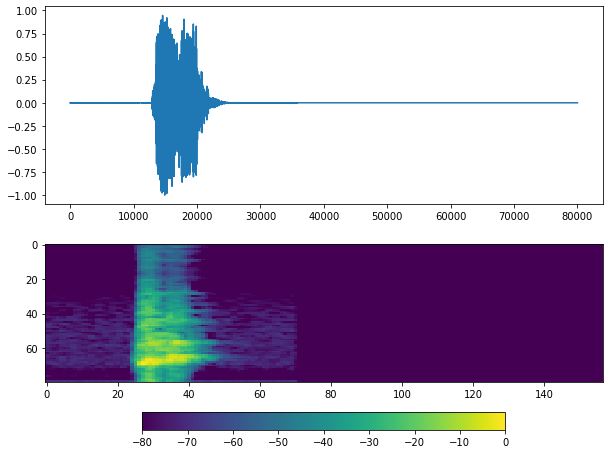

In [4]:
files = os.listdir(X_train_dir)
files.sort()
f = files[40]
y, sr = malaya_speech.load(X_train_dir+f)
plot(y,sr)
ipd.Audio(y, rate = sr)

# 取基頻

mel shape: (1, 80)


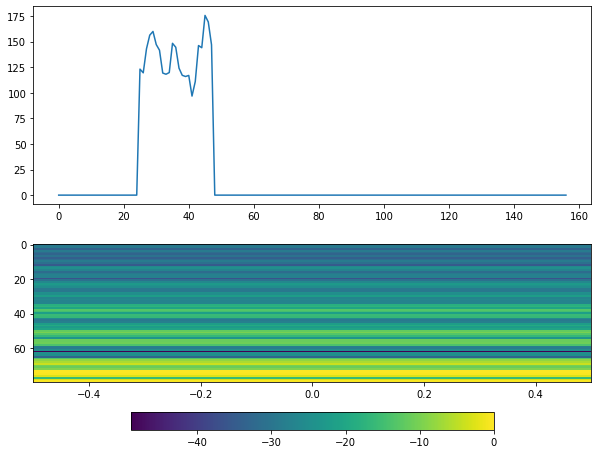

In [5]:
y_基頻 = rapt(y.astype('float32')*32767,sr,hopsize=512)
plot(y_基頻,sr)
ipd.Audio(y_基頻, rate = sr)

# 靜音部分消除

In [6]:
quantized_model = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)
p = Pipeline()

pipeline_left = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 30, sample_rate = 16000)
)

pipeline_right = (
    pipeline_left.batching(5)
    .foreach_map(quantized_model.predict)
    .flatten()
)

pipeline_left.foreach_zip(pipeline_right).map(malaya_speech.combine.without_silent,
                                             threshold_to_stop = 0.05)

p.visualize()

ConnectionError: HTTPSConnectionPool(host='f000.backblazeb2.com', port=443): Max retries exceeded with url: /file/malaya-speech-model/vad/vggvox-v2-quantized/model.pb (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fecd4ca5510>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

In [7]:
def remove_silent(y,sr,time_length=80000):
    y =  p(y)['without_silent']
    if len(y) > time_length:
        y = y[0:0+time_length]
    else:
        y = np.pad(y, (0,time_length-len(y)))
    return y

In [8]:
y_without_silent = remove_silent(y,sr)
plot(y_without_silent,sr)
ipd.Audio(y_without_silent, rate = sr)

NameError: name 'p' is not defined

# mel shape: (157, 80) #固定

# wav 2 features flow

In [ ]:
def wav2featuresflow(y, sr):
    y_without_silent = remove_silent(y,sr)
    melspectrogram = np.rot90(norm_mel(y, sr))
    return melspectrogram

In [ ]:
files = os.listdir(X_train_dir)
files.sort()
for f in files[::120]:
    y,sr = malaya_speech.load(X_train_dir+f)
    melspectrogram = wav2featuresflow(y,sr=16000)
    plt.imshow(melspectrogram)
    plt.title(f)
    plt.show()

# preprocessing 

In [15]:
def preprocessing_X(wav_dir):
    files = os.listdir(wav_dir)
    files.sort() #正確排序很重要!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    X = torch.FloatTensor([])
    for f in tqdm(files[:]):
        try:
            samples, sample_rate = malaya_speech.load(X_train_dir+f)
            melspectrogram = wav2featuresflow(samples,sr=sample_rate)
            melspectrogram = melspectrogram.reshape(-1,80,157).copy()
            melspectrogram = torch.from_numpy(melspectrogram)
            X = torch.cat([X,torch.unsqueeze(melspectrogram,0)],dim=0)
            gc.collect()
        except:
            print(f)
    print('X shape:',X.shape)
    return X

def preprocessing_Y(file_path):
    Y = pd.read_csv(file_path).iloc[:,:]
    Y = Y[Y.Filename != 'train_01046']
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    Y_one_hot = torch.FloatTensor(Y_one_hot)
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

# Load X

In [299]:
#X_train = preprocessing_X(X_train_dir)
#torch.save(X_train,'X_train_吳啟聖教的方法.pt')

In [328]:
X_train = torch.load('X_train_吳啟聖教的方法.pt')

In [329]:
#X_test = preprocessing_X(X_test_dir)
#torch.save(X_test,'X_test_吳啟聖教的方法.pt')

In [330]:
X_test = torch.load('X_test_吳啟聖教的方法.pt')

In [331]:
gc.collect()

7861

In [332]:
X_train.shape,X_test.shape

(torch.Size([1199, 1, 80, 157]), torch.Size([10000, 1, 80, 157]))

# load Y

In [333]:
Y_train,Y_train_df = preprocessing_Y(Y_train_path)
print(Y_train.shape)
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

Y_ont_hot shape torch.Size([1199, 6])
Y_df shape (1199, 3)
torch.Size([1199, 6])


{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Electrics'}

# look some sample

In [334]:
def plot_feature_by_class_name(class_name,X,label_df):
    try:
        plt.figure(figsize=(20,5))
        for i,filename in enumerate([i+'.wav' for i in label_df[label_df.Remark==class_name].sample(3)['Filename'].values]):
            feature = X[int(filename.split('_')[1].split('.')[0])]
            plt.subplot(1,3,i+1)
            plt.imshow(feature[0,:,:])
            title = 'class:{} filename:{}'.format(class_name,filename)
            plt.title(title)
        plt.tight_layout()
        plt.show()
    except:
        print(class_name)

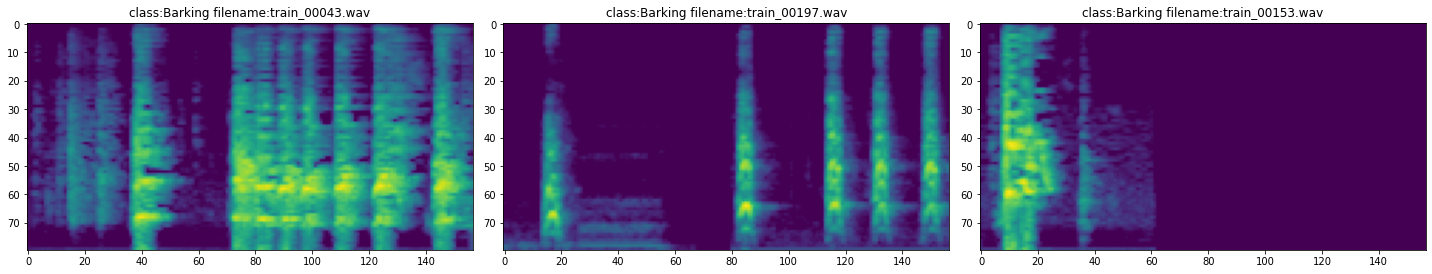

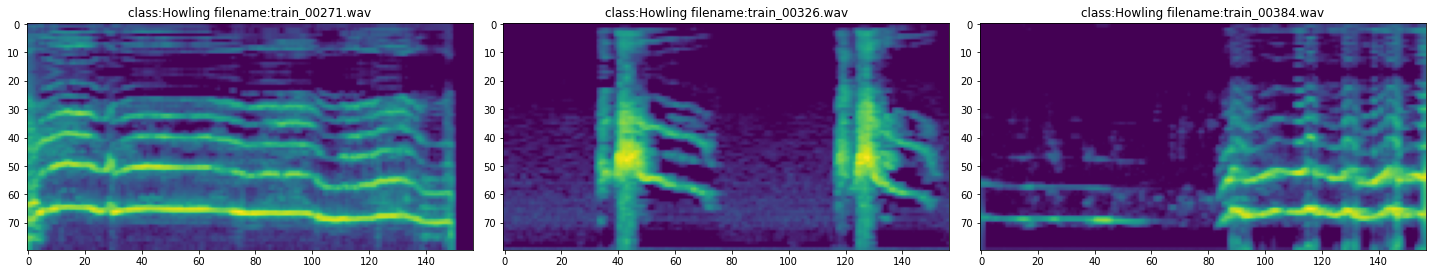

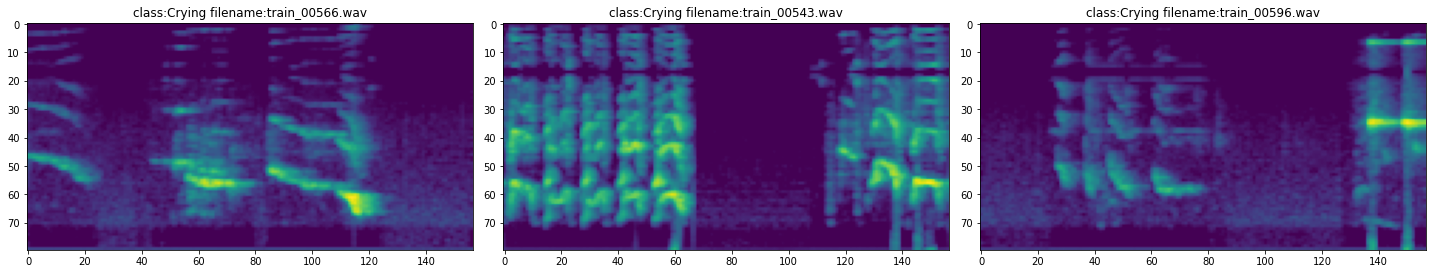

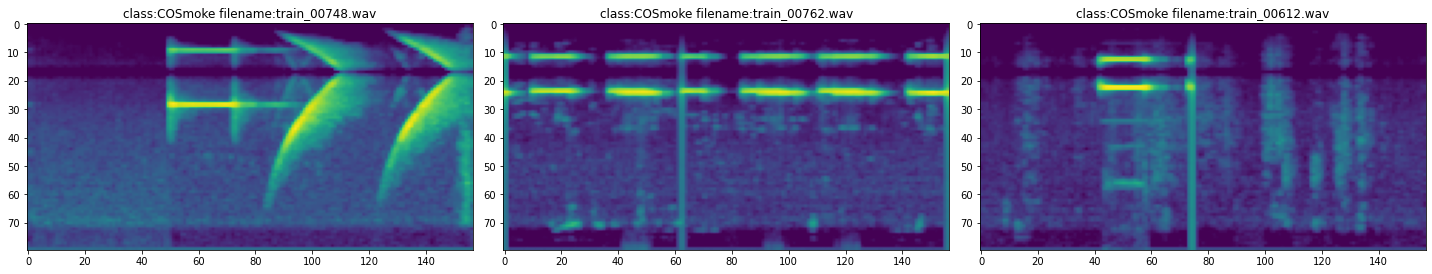

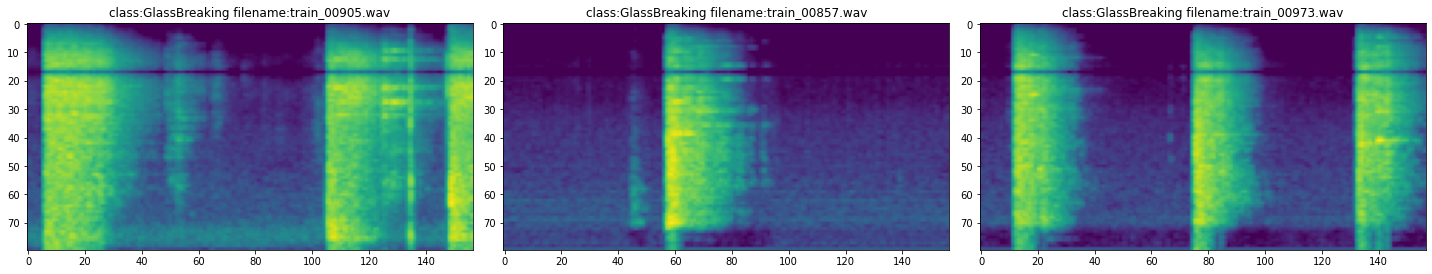

Other


<Figure size 1440x360 with 0 Axes>

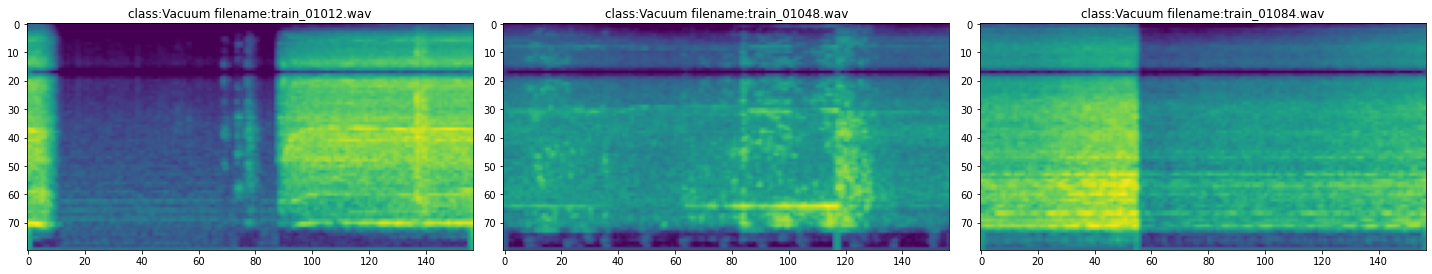

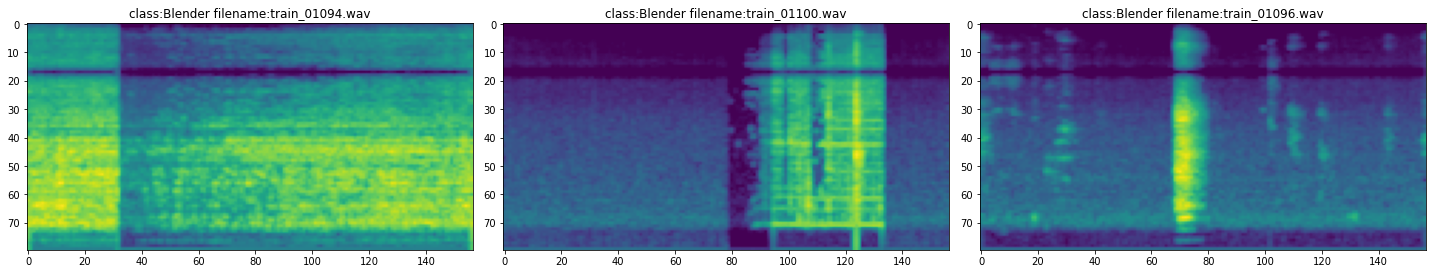

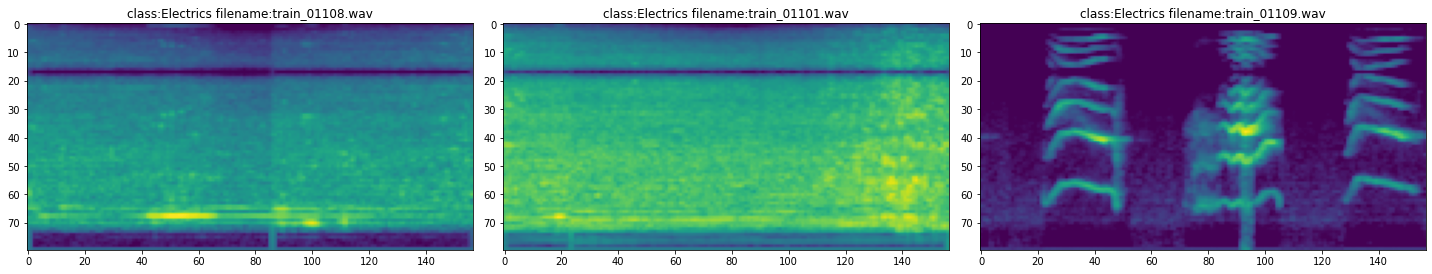

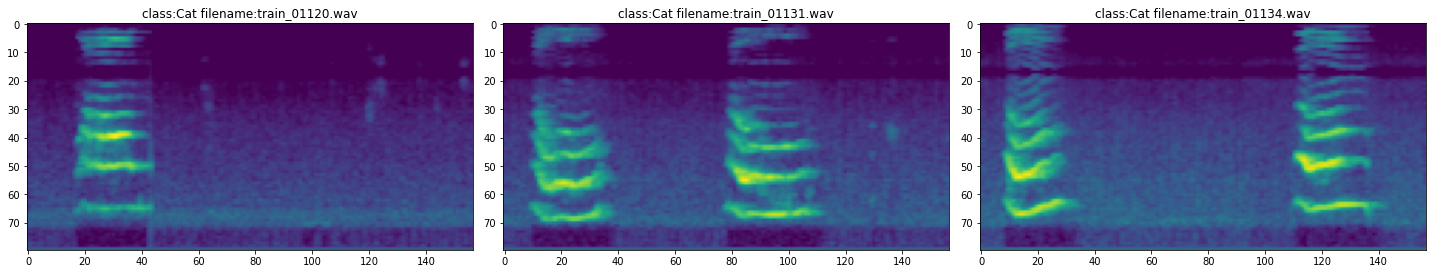

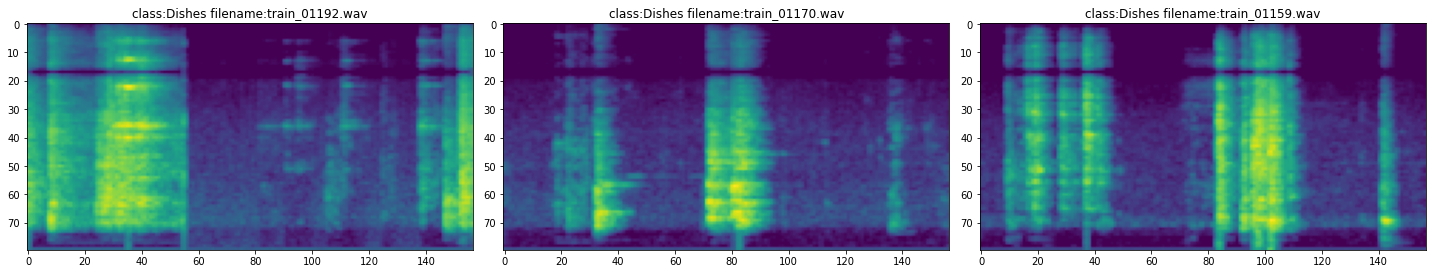

In [335]:
for class_name in Y_train_df.Remark.unique():
    plot_feature_by_class_name(class_name,X_train,Y_train_df)

# train valid split

In [336]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42,stratify=Y_train)
print(X_train.shape)
print(X_valid.shape)
print(pd.DataFrame(y_train.argmax(axis=1)).value_counts())
print(pd.DataFrame(y_valid.argmax(axis=1)).value_counts())

torch.Size([959, 1, 80, 157])
torch.Size([240, 1, 80, 157])
0    160
1    160
2    160
3    160
5    160
4    159
dtype: int64
0    40
1    40
2    40
3    40
4    40
5    40
dtype: int64


# 加入外部數據 to X_train

In [337]:
import joblib
expansion_data = joblib.load('expansion_data.pkl')
for k in expansion_data.keys():
    print(k,len(expansion_data[k]))

Electricssound 20
dogbarking 260
GlassBreakingsound 13
dogcrying 25
Vaccumsound 116
doghowling 18
dishessound 42
Catsound 176


In [338]:
class_idx_map_dict = {}
class_idx_map_dict['dogbarking'] = 0
class_idx_map_dict['doghowling'] = 1
class_idx_map_dict['dogcrying'] = 2
class_idx_map_dict['GlassBreakingsound'] = 4
class_idx_map_dict['Electricssound'] = 5
class_idx_map_dict['Vaccumsound'] = 5
class_idx_map_dict['dishessound'] = 5
class_idx_map_dict['Catsound'] = 5

In [342]:
def create_label(batch_size,length=6,class_idx=0):
    y = torch.tensor([[class_idx] for _ in range(batch_size)])
    y_onehot = torch.zeros([batch_size, length])
    return y_onehot.scatter_(1, y, 1)

extra_X_train = torch.FloatTensor([])
extra_y_train = torch.FloatTensor([])
data_idx = {}
for class_name in tqdm(expansion_data.keys()):
    data = expansion_data[class_name][[*range(5,10,1)]]
    label = create_label(batch_size=len(data),length=6,class_idx=class_idx_map_dict[class_name])
    extra_X_train = torch.cat([extra_X_train,data],dim=0)
    extra_y_train = torch.cat([extra_y_train,label],dim=0)
extra_X_train.shape,extra_y_train.shape

100%|██████████| 8/8 [00:00<00:00, 523.85it/s]


(torch.Size([40, 1, 80, 157]), torch.Size([40, 6]))

In [343]:
print(expansion_data.keys())

dict_keys(['Electricssound', 'dogbarking', 'GlassBreakingsound', 'dogcrying', 'Vaccumsound', 'doghowling', 'dishessound', 'Catsound'])


# 檢視外部數據

In [344]:
extra_label_df = pd.DataFrame(extra_y_train.argmax(axis=1).detach().numpy(),columns = ['class_name'])
extra_label_df

class_name
0            5
1            5
2            5
3            5
4            5
5            0
6            0
7            0
8            0
9            0
10           4
11           4
12           4
13           4
14           4
15           2
16           2
17           2
18           2
19           2
20           5
21           5
22           5
23           5
24           5
25           1
26           1
27           1
28           1
29           1
30           5
31           5
32           5
33           5
34           5
35           5
36           5
37           5
38           5
39           5

In [345]:
def plot_feature_by_class_name(class_name,X,label_df):
    plt.figure(figsize=(20,5))
    i = 0
    for idx,file_idx in enumerate(label_df[label_df.class_name==class_name].sample(3).index):
        feature = X[int(file_idx)]
        plt.subplot(1,3,i+1)
        plt.imshow(feature[0,:,:])
        title = 'class:{} file_idx:{}'.format(class_name,file_idx)
        plt.title(title)
        i+=1
    plt.tight_layout()
    plt.show()

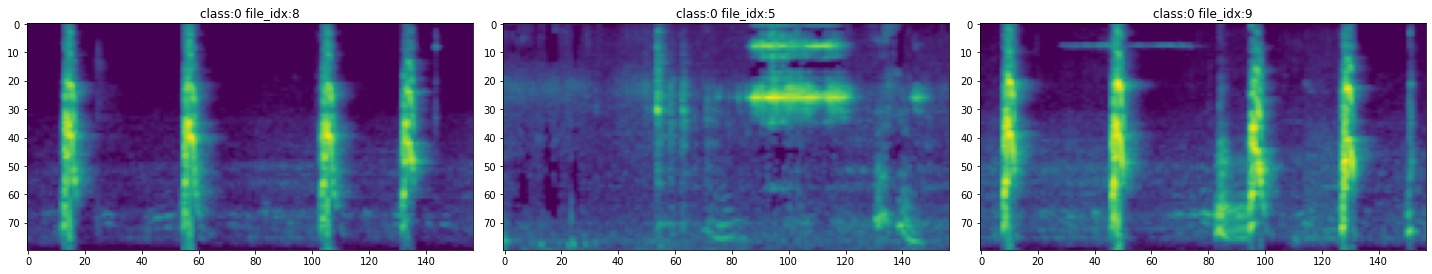

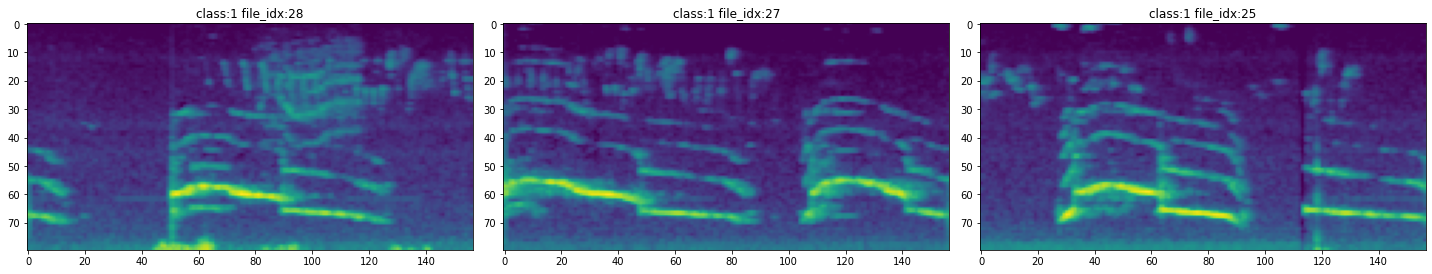

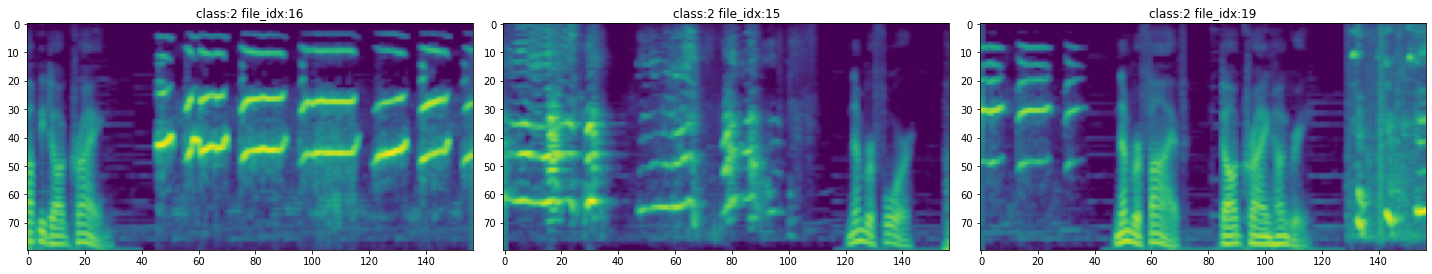

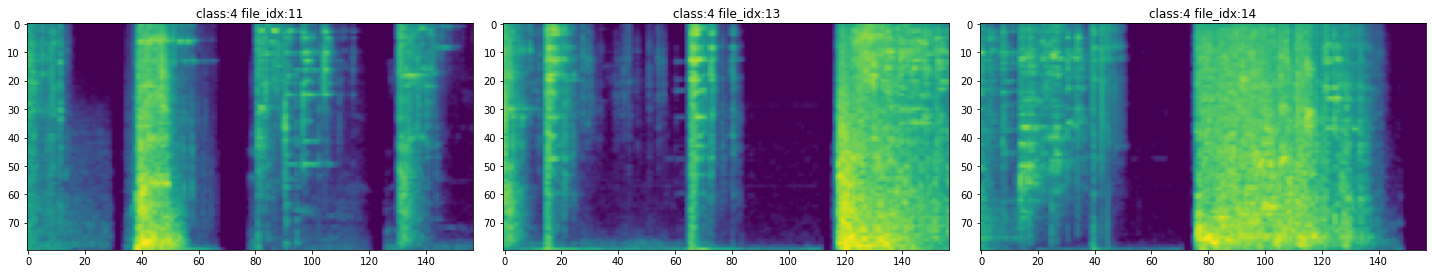

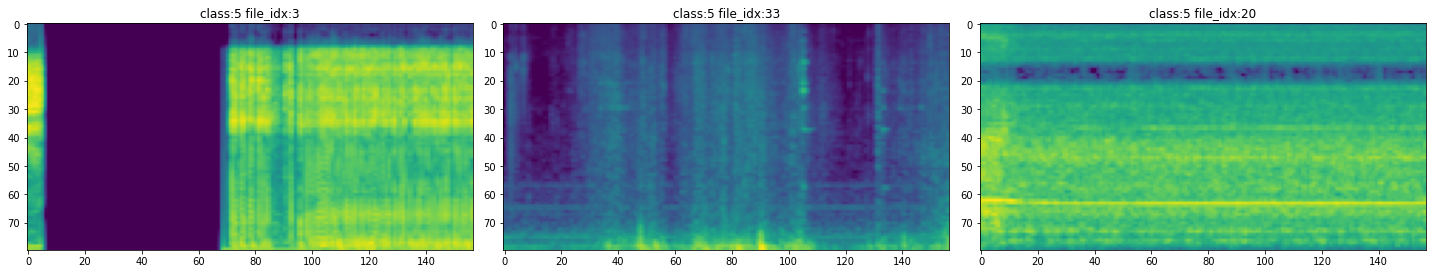

In [346]:
for class_name in sorted(extra_label_df.class_name.unique()):
    plot_feature_by_class_name(class_name,extra_X_train,extra_label_df)

In [347]:
X_train = torch.cat([X_train,extra_X_train],dim=0)
X_train.shape

torch.Size([999, 1, 80, 157])

In [348]:
y_train = torch.cat([y_train,extra_y_train],dim=0)
y_train.shape

torch.Size([999, 6])

In [349]:
X_valid.shape

torch.Size([240, 1, 80, 157])

In [350]:
y_valid.shape

torch.Size([240, 6])

#  create pytorch dataloader and save

In [351]:
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
train_iter = DataLoader(trainset,batch_size=32,num_workers=4)
vaild_iter = DataLoader(vaildset,batch_size=32,num_workers=4)

In [352]:
for bx,by in train_iter:
    print(bx.shape,bx.device) # batch,channel,freq,time
    print(by.shape,by.device) # batch,n_class
    break

torch.Size([32, 1, 80, 157]) cpu
torch.Size([32, 6]) cpu


# define model

In [353]:
import torch.hub
model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet20',
    num_classes=6)
model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
print(model)

CifarSEResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): CifarSEBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=16, out_features=1, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=1, out_features=16, bias=False)
          (3): Sigmoid()
        )
      )
    )
    (1)

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


# model forward test

In [354]:
y_hat = model(bx)
print(bx.shape,y_hat.shape)
y_hat.shape

torch.Size([32, 1, 80, 157]) torch.Size([32, 6])


torch.Size([32, 6])

# def train loop

In [355]:
from sklearn.metrics import accuracy_score

def train_step(model,train_iter,loss_fn,optimizer,device):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

def valid_step(model,vaild_iter,loss_fn,optimizer,device):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

def softmax2onehot(probs):
  probs = torch.FloatTensor(probs)
  max_idx = torch.argmax(probs, 1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.detach().cpu().numpy().astype(int)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    y_hat = model(x).argmax(dim=1).detach().cpu().numpy()
    y = y.argmax(dim=1).detach().cpu().numpy()
    return accuracy_score(y,y_hat)
    #return 0 #roc_auc_score(y_hat,y)


# train_loop
def train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=300,log_interval=10,device=None):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        current_loss = np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer,device)
            valid_loss,valid_auc = valid_step(model,vaild_iter,loss_fn,optimizer,device)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_loss'][-1] <= current_loss:
                best_model = deepcopy(model.eval())
                current_loss = history['valid_loss'][-1]
                print('有進步')
            gc.collect()
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
        
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model

  1%|          | 1/100 [00:06<10:30,  6.37s/it]

epoch:0 train_loss:0.4184 valid_loss:0.3959 train_auc:0.4611 valid_auc:0.4570
有進步


  2%|▏         | 2/100 [00:12<10:15,  6.28s/it]

epoch:1 train_loss:0.3137 valid_loss:0.2543 train_auc:0.6325 valid_auc:0.6484
有進步


  3%|▎         | 3/100 [00:18<09:59,  6.18s/it]

epoch:2 train_loss:0.2731 valid_loss:0.4185 train_auc:0.7015 valid_auc:0.4414
epoch:3 train_loss:0.2460 valid_loss:0.1938 train_auc:0.7386 valid_auc:0.7422
有進步


  5%|▌         | 5/100 [00:30<09:45,  6.17s/it]

epoch:4 train_loss:0.2246 valid_loss:0.4756 train_auc:0.7464 valid_auc:0.5078


  6%|▌         | 6/100 [00:37<09:42,  6.20s/it]

epoch:5 train_loss:0.2085 valid_loss:0.1831 train_auc:0.7708 valid_auc:0.7773
有進步


  7%|▋         | 7/100 [00:43<09:34,  6.18s/it]

epoch:6 train_loss:0.1925 valid_loss:0.2069 train_auc:0.7835 valid_auc:0.7461


  8%|▊         | 8/100 [00:49<09:29,  6.19s/it]

epoch:7 train_loss:0.1769 valid_loss:0.1911 train_auc:0.8083 valid_auc:0.7773


  9%|▉         | 9/100 [00:55<09:26,  6.23s/it]

epoch:8 train_loss:0.1671 valid_loss:0.1778 train_auc:0.8270 valid_auc:0.7930
有進步


 10%|█         | 10/100 [01:02<09:18,  6.20s/it]

epoch:9 train_loss:0.1551 valid_loss:0.4497 train_auc:0.8391 valid_auc:0.6289


 11%|█         | 11/100 [01:08<09:09,  6.17s/it]

epoch:10 train_loss:0.1393 valid_loss:0.4575 train_auc:0.8598 valid_auc:0.6758


 12%|█▏        | 12/100 [01:15<09:42,  6.61s/it]

epoch:11 train_loss:0.1371 valid_loss:0.4597 train_auc:0.8626 valid_auc:0.6289


 13%|█▎        | 13/100 [01:21<09:22,  6.46s/it]

epoch:12 train_loss:0.1304 valid_loss:0.8012 train_auc:0.8710 valid_auc:0.4805


 14%|█▍        | 14/100 [01:28<09:17,  6.49s/it]

epoch:13 train_loss:0.1239 valid_loss:0.3856 train_auc:0.8867 valid_auc:0.6719


 15%|█▌        | 15/100 [01:34<09:03,  6.40s/it]

epoch:14 train_loss:0.1127 valid_loss:1.0729 train_auc:0.8905 valid_auc:0.4336


 16%|█▌        | 16/100 [01:40<08:53,  6.35s/it]

epoch:15 train_loss:0.1115 valid_loss:0.3981 train_auc:0.8959 valid_auc:0.5977


 17%|█▋        | 17/100 [01:47<08:54,  6.44s/it]

epoch:16 train_loss:0.1134 valid_loss:0.2506 train_auc:0.9051 valid_auc:0.7070


 18%|█▊        | 18/100 [01:53<08:42,  6.37s/it]

epoch:17 train_loss:0.0967 valid_loss:0.2064 train_auc:0.9129 valid_auc:0.7773


 19%|█▉        | 19/100 [02:00<08:40,  6.43s/it]

epoch:18 train_loss:0.0841 valid_loss:0.1523 train_auc:0.9290 valid_auc:0.8516
有進步


 20%|██        | 20/100 [02:06<08:26,  6.33s/it]

epoch:19 train_loss:0.0835 valid_loss:0.1460 train_auc:0.9291 valid_auc:0.8438
有進步
epoch:20 train_loss:0.0752 valid_loss:0.1284 train_auc:0.9446 valid_auc:0.8516
有進步


 22%|██▏       | 22/100 [02:18<08:08,  6.27s/it]

epoch:21 train_loss:0.0730 valid_loss:0.1507 train_auc:0.9463 valid_auc:0.8242


 23%|██▎       | 23/100 [02:25<08:02,  6.26s/it]

epoch:22 train_loss:0.0672 valid_loss:0.3092 train_auc:0.9530 valid_auc:0.6875


 24%|██▍       | 24/100 [02:31<07:55,  6.26s/it]

epoch:23 train_loss:0.0636 valid_loss:0.1940 train_auc:0.9574 valid_auc:0.8164


 25%|██▌       | 25/100 [02:37<07:45,  6.20s/it]

epoch:24 train_loss:0.0537 valid_loss:0.1831 train_auc:0.9653 valid_auc:0.7969


 26%|██▌       | 26/100 [02:43<07:37,  6.18s/it]

epoch:25 train_loss:0.0473 valid_loss:0.2214 train_auc:0.9731 valid_auc:0.7539


 27%|██▋       | 27/100 [02:49<07:33,  6.21s/it]

epoch:26 train_loss:0.0471 valid_loss:0.1922 train_auc:0.9785 valid_auc:0.8164


 28%|██▊       | 28/100 [02:56<07:29,  6.24s/it]

epoch:27 train_loss:0.0468 valid_loss:0.1648 train_auc:0.9750 valid_auc:0.8125


 29%|██▉       | 29/100 [03:02<07:20,  6.21s/it]

epoch:28 train_loss:0.0512 valid_loss:0.1652 train_auc:0.9662 valid_auc:0.8281


 30%|███       | 30/100 [03:08<07:14,  6.21s/it]

epoch:29 train_loss:0.0478 valid_loss:0.1786 train_auc:0.9721 valid_auc:0.8242


 31%|███       | 31/100 [03:15<07:32,  6.56s/it]

epoch:30 train_loss:0.0435 valid_loss:0.1610 train_auc:0.9717 valid_auc:0.8281


 32%|███▏      | 32/100 [03:22<07:26,  6.56s/it]

epoch:31 train_loss:0.0470 valid_loss:0.1480 train_auc:0.9697 valid_auc:0.8320


 33%|███▎      | 33/100 [03:28<07:11,  6.44s/it]

epoch:32 train_loss:0.0404 valid_loss:0.1171 train_auc:0.9795 valid_auc:0.8828
有進步


 34%|███▍      | 34/100 [03:34<06:58,  6.35s/it]

epoch:33 train_loss:0.0346 valid_loss:0.1845 train_auc:0.9844 valid_auc:0.8477


 35%|███▌      | 35/100 [03:40<06:51,  6.34s/it]

epoch:34 train_loss:0.0278 valid_loss:0.2663 train_auc:0.9883 valid_auc:0.8203


 36%|███▌      | 36/100 [03:47<06:46,  6.35s/it]

epoch:35 train_loss:0.0252 valid_loss:0.1379 train_auc:0.9902 valid_auc:0.8789


 37%|███▋      | 37/100 [03:53<06:38,  6.33s/it]

epoch:36 train_loss:0.0231 valid_loss:0.1389 train_auc:0.9922 valid_auc:0.8789


 38%|███▊      | 38/100 [03:59<06:30,  6.30s/it]

epoch:37 train_loss:0.0157 valid_loss:0.1335 train_auc:0.9980 valid_auc:0.8789


 39%|███▉      | 39/100 [04:06<06:21,  6.26s/it]

epoch:38 train_loss:0.0169 valid_loss:0.1427 train_auc:0.9916 valid_auc:0.8672


 40%|████      | 40/100 [04:12<06:12,  6.20s/it]

epoch:39 train_loss:0.0144 valid_loss:0.1467 train_auc:0.9980 valid_auc:0.8672


 41%|████      | 41/100 [04:18<06:10,  6.28s/it]

epoch:40 train_loss:0.0122 valid_loss:0.1217 train_auc:0.9990 valid_auc:0.8867


 42%|████▏     | 42/100 [04:24<06:04,  6.28s/it]

epoch:41 train_loss:0.0138 valid_loss:0.1374 train_auc:0.9932 valid_auc:0.8984


 43%|████▎     | 43/100 [04:31<05:57,  6.27s/it]

epoch:42 train_loss:0.0342 valid_loss:0.2193 train_auc:0.9746 valid_auc:0.8086


 44%|████▍     | 44/100 [04:37<05:48,  6.23s/it]

epoch:43 train_loss:0.0227 valid_loss:0.1757 train_auc:0.9863 valid_auc:0.8398


 45%|████▌     | 45/100 [04:43<05:41,  6.21s/it]

epoch:44 train_loss:0.0169 valid_loss:0.1693 train_auc:0.9951 valid_auc:0.8633


 46%|████▌     | 46/100 [04:49<05:32,  6.16s/it]

epoch:45 train_loss:0.0131 valid_loss:0.1278 train_auc:0.9941 valid_auc:0.8867


 47%|████▋     | 47/100 [04:55<05:26,  6.17s/it]

epoch:46 train_loss:0.0178 valid_loss:0.1982 train_auc:0.9932 valid_auc:0.8320


 48%|████▊     | 48/100 [05:01<05:19,  6.15s/it]

epoch:47 train_loss:0.0273 valid_loss:0.2921 train_auc:0.9834 valid_auc:0.7812


 49%|████▉     | 49/100 [05:08<05:16,  6.20s/it]

epoch:48 train_loss:0.0321 valid_loss:0.2362 train_auc:0.9717 valid_auc:0.7969


 50%|█████     | 50/100 [05:14<05:12,  6.25s/it]

epoch:49 train_loss:0.0250 valid_loss:0.1602 train_auc:0.9873 valid_auc:0.8828


 51%|█████     | 51/100 [05:21<05:21,  6.55s/it]

epoch:50 train_loss:0.0180 valid_loss:0.1306 train_auc:0.9848 valid_auc:0.8867


 52%|█████▏    | 52/100 [05:27<05:11,  6.48s/it]

epoch:51 train_loss:0.0110 valid_loss:0.1290 train_auc:0.9990 valid_auc:0.8906


 53%|█████▎    | 53/100 [05:34<05:01,  6.41s/it]

epoch:52 train_loss:0.0069 valid_loss:0.1686 train_auc:1.0000 valid_auc:0.8555


 54%|█████▍    | 54/100 [05:40<04:54,  6.40s/it]

epoch:53 train_loss:0.0065 valid_loss:0.1613 train_auc:0.9990 valid_auc:0.8711


 55%|█████▌    | 55/100 [05:46<04:45,  6.34s/it]

epoch:54 train_loss:0.0083 valid_loss:0.1283 train_auc:0.9971 valid_auc:0.8828


 56%|█████▌    | 56/100 [05:53<04:39,  6.35s/it]

epoch:55 train_loss:0.0047 valid_loss:0.1218 train_auc:0.9990 valid_auc:0.8828


 57%|█████▋    | 57/100 [05:59<04:34,  6.38s/it]

epoch:56 train_loss:0.0039 valid_loss:0.1280 train_auc:1.0000 valid_auc:0.8945


 58%|█████▊    | 58/100 [06:05<04:27,  6.37s/it]

epoch:57 train_loss:0.0029 valid_loss:0.1412 train_auc:1.0000 valid_auc:0.8789


 59%|█████▉    | 59/100 [06:12<04:20,  6.35s/it]

epoch:58 train_loss:0.0023 valid_loss:0.1358 train_auc:1.0000 valid_auc:0.8945


 60%|██████    | 60/100 [06:18<04:15,  6.38s/it]

epoch:59 train_loss:0.0022 valid_loss:0.1364 train_auc:1.0000 valid_auc:0.8906


 61%|██████    | 61/100 [06:25<04:09,  6.41s/it]

epoch:60 train_loss:0.0029 valid_loss:0.1403 train_auc:1.0000 valid_auc:0.8789


 62%|██████▏   | 62/100 [06:31<04:02,  6.39s/it]

epoch:61 train_loss:0.0020 valid_loss:0.1393 train_auc:1.0000 valid_auc:0.8906


 63%|██████▎   | 63/100 [06:37<03:56,  6.39s/it]

epoch:62 train_loss:0.0017 valid_loss:0.1379 train_auc:1.0000 valid_auc:0.8906


 64%|██████▍   | 64/100 [06:44<03:49,  6.37s/it]

epoch:63 train_loss:0.0016 valid_loss:0.1400 train_auc:1.0000 valid_auc:0.8867


 65%|██████▌   | 65/100 [06:50<03:39,  6.27s/it]

epoch:64 train_loss:0.0015 valid_loss:0.1423 train_auc:1.0000 valid_auc:0.8867


 66%|██████▌   | 66/100 [06:56<03:32,  6.25s/it]

epoch:65 train_loss:0.0014 valid_loss:0.1436 train_auc:1.0000 valid_auc:0.8867


 67%|██████▋   | 67/100 [07:02<03:27,  6.28s/it]

epoch:66 train_loss:0.0013 valid_loss:0.1453 train_auc:1.0000 valid_auc:0.8867


 68%|██████▊   | 68/100 [07:08<03:19,  6.23s/it]

epoch:67 train_loss:0.0012 valid_loss:0.1469 train_auc:1.0000 valid_auc:0.8867


 69%|██████▉   | 69/100 [07:15<03:13,  6.25s/it]

epoch:68 train_loss:0.0012 valid_loss:0.1485 train_auc:1.0000 valid_auc:0.8828


 70%|███████   | 70/100 [07:23<03:21,  6.72s/it]

epoch:69 train_loss:0.0011 valid_loss:0.1499 train_auc:1.0000 valid_auc:0.8867


 71%|███████   | 71/100 [07:29<03:10,  6.58s/it]

epoch:70 train_loss:0.0011 valid_loss:0.1510 train_auc:1.0000 valid_auc:0.8828


 72%|███████▏  | 72/100 [07:35<03:02,  6.52s/it]

epoch:71 train_loss:0.0010 valid_loss:0.1523 train_auc:1.0000 valid_auc:0.8867


 73%|███████▎  | 73/100 [07:41<02:53,  6.42s/it]

epoch:72 train_loss:0.0010 valid_loss:0.1534 train_auc:1.0000 valid_auc:0.8867


 74%|███████▍  | 74/100 [07:48<02:44,  6.34s/it]

epoch:73 train_loss:0.0009 valid_loss:0.1546 train_auc:1.0000 valid_auc:0.8867


 75%|███████▌  | 75/100 [07:54<02:39,  6.37s/it]

epoch:74 train_loss:0.0009 valid_loss:0.1557 train_auc:1.0000 valid_auc:0.8867


 76%|███████▌  | 76/100 [08:01<02:34,  6.44s/it]

epoch:75 train_loss:0.0009 valid_loss:0.1568 train_auc:1.0000 valid_auc:0.8867


 77%|███████▋  | 77/100 [08:07<02:25,  6.33s/it]

epoch:76 train_loss:0.0008 valid_loss:0.1578 train_auc:1.0000 valid_auc:0.8867


 78%|███████▊  | 78/100 [08:13<02:20,  6.38s/it]

epoch:77 train_loss:0.0008 valid_loss:0.1588 train_auc:1.0000 valid_auc:0.8906


 79%|███████▉  | 79/100 [08:20<02:14,  6.40s/it]

epoch:78 train_loss:0.0008 valid_loss:0.1598 train_auc:1.0000 valid_auc:0.8906


 80%|████████  | 80/100 [08:26<02:07,  6.38s/it]

epoch:79 train_loss:0.0007 valid_loss:0.1607 train_auc:1.0000 valid_auc:0.8906


 81%|████████  | 81/100 [08:32<02:00,  6.33s/it]

epoch:80 train_loss:0.0007 valid_loss:0.1615 train_auc:1.0000 valid_auc:0.8906


 82%|████████▏ | 82/100 [08:38<01:52,  6.27s/it]

epoch:81 train_loss:0.0007 valid_loss:0.1625 train_auc:1.0000 valid_auc:0.8906


 83%|████████▎ | 83/100 [08:45<01:46,  6.29s/it]

epoch:82 train_loss:0.0007 valid_loss:0.1633 train_auc:1.0000 valid_auc:0.8906


 84%|████████▍ | 84/100 [08:51<01:39,  6.23s/it]

epoch:83 train_loss:0.0006 valid_loss:0.1642 train_auc:1.0000 valid_auc:0.8906


 85%|████████▌ | 85/100 [08:57<01:33,  6.26s/it]

epoch:84 train_loss:0.0006 valid_loss:0.1650 train_auc:1.0000 valid_auc:0.8906


 86%|████████▌ | 86/100 [09:03<01:27,  6.24s/it]

epoch:85 train_loss:0.0006 valid_loss:0.1658 train_auc:1.0000 valid_auc:0.8945


 87%|████████▋ | 87/100 [09:09<01:20,  6.23s/it]

epoch:86 train_loss:0.0006 valid_loss:0.1668 train_auc:1.0000 valid_auc:0.8906


 88%|████████▊ | 88/100 [09:16<01:14,  6.23s/it]

epoch:87 train_loss:0.0006 valid_loss:0.1674 train_auc:1.0000 valid_auc:0.8906


 89%|████████▉ | 89/100 [09:23<01:11,  6.49s/it]

epoch:88 train_loss:0.0005 valid_loss:0.1684 train_auc:1.0000 valid_auc:0.8906


 90%|█████████ | 90/100 [09:29<01:04,  6.49s/it]

epoch:89 train_loss:0.0005 valid_loss:0.1689 train_auc:1.0000 valid_auc:0.8906


 91%|█████████ | 91/100 [09:36<00:58,  6.45s/it]

epoch:90 train_loss:0.0005 valid_loss:0.1702 train_auc:1.0000 valid_auc:0.8945


 92%|█████████▏| 92/100 [09:42<00:51,  6.47s/it]

epoch:91 train_loss:0.0005 valid_loss:0.1707 train_auc:1.0000 valid_auc:0.8945


 93%|█████████▎| 93/100 [09:48<00:44,  6.42s/it]

epoch:92 train_loss:0.0005 valid_loss:0.1720 train_auc:1.0000 valid_auc:0.8945


 94%|█████████▍| 94/100 [09:55<00:38,  6.38s/it]

epoch:93 train_loss:0.0005 valid_loss:0.1724 train_auc:1.0000 valid_auc:0.8906


 95%|█████████▌| 95/100 [10:01<00:31,  6.34s/it]

epoch:94 train_loss:0.0004 valid_loss:0.1736 train_auc:1.0000 valid_auc:0.8945


 96%|█████████▌| 96/100 [10:07<00:25,  6.33s/it]

epoch:95 train_loss:0.0004 valid_loss:0.1740 train_auc:1.0000 valid_auc:0.8906


 97%|█████████▋| 97/100 [10:13<00:18,  6.30s/it]

epoch:96 train_loss:0.0004 valid_loss:0.1752 train_auc:1.0000 valid_auc:0.8945


 98%|█████████▊| 98/100 [10:20<00:12,  6.31s/it]

epoch:97 train_loss:0.0004 valid_loss:0.1758 train_auc:1.0000 valid_auc:0.8906


 99%|█████████▉| 99/100 [10:26<00:06,  6.23s/it]

epoch:98 train_loss:0.0004 valid_loss:0.1767 train_auc:1.0000 valid_auc:0.8945


100%|██████████| 100/100 [10:32<00:00,  6.33s/it]

epoch:99 train_loss:0.0004 valid_loss:0.1775 train_auc:1.0000 valid_auc:0.8945


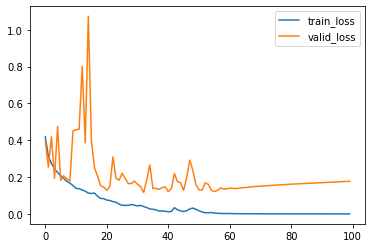

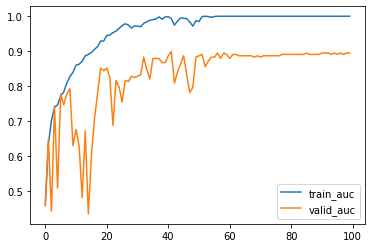

In [356]:
device = 'cuda:0'
model = model.to(device)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
optimizer = Adam(model.parameters(),lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=100,log_interval=1,device=device)

In [357]:
torch.save(model.state_dict(),'senet20_2021_0604_0750.pt')

In [358]:
model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet20',
    num_classes=6)
model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.eval()
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


In [359]:
model.load_state_dict(torch.load('senet20_2021_0604_0750.pt'))

<All keys matched successfully>

# model infernce test

In [360]:
from sklearn.metrics import confusion_matrix,accuracy_score
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    acc = accuracy_score(y_pred,y_true)
    return cm,acc

In [361]:
cm,acc = plot_confusion_matrix(model.to(device),train_iter)
print(acc)
cm

100%|██████████| 32/32 [00:02<00:00, 14.52it/s]

0.9669669669669669


Barking  Howling  Crying  COSmoke  GlassBreaking  Electrics
0      157        0       1        1              0          0
1        4      159       5        0              0          1
2        4        6     159        0              0          7
3        0        0       0      159              0          0
4        0        0       0        0            163          3
5        0        0       0        0              1        169

In [362]:
cm,acc = plot_confusion_matrix(model.to(device),vaild_iter)
print(acc)
cm

100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

0.8833333333333333


Barking  Howling  Crying  COSmoke  GlassBreaking  Electrics
0       32        0       1        1              0          0
1        2       36       7        0              0          0
2        5        2      32        1              1          3
3        0        0       0       38              0          0
4        1        0       0        0             38          1
5        0        2       0        0              1         36

# submit

In [363]:
print(X_test.shape[0])

10000


In [374]:
sample_submit = pd.read_csv('sample_submission.csv')
model = model.to('cuda:0')
model.eval()
batch = 100
for i in tqdm(range(0,X_test.shape[0]-batch+1,batch)):
    sample_submit.iloc[i:i+batch,1:] = model(X_test[i:i+batch].to(torch.float32).cuda()).detach().cpu().numpy()
sample_submit

100%|██████████| 100/100 [00:03<00:00, 26.86it/s]


Filename   Barking    Howling    Crying   COSmoke  GlassBreaking  \
0       public_00001 -9.551540  -9.705976 -0.014147 -8.348824      -5.420249   
1       public_00002 -7.598464  -9.527964 -5.124302 -4.961715      -7.892138   
2       public_00003  4.482255  -7.222614 -5.214307 -7.247753      -7.747019   
3       public_00004 -9.356022 -14.298517 -3.892609 -4.540806      -2.857344   
4       public_00005  0.707826  -6.190164  0.682545 -6.043875      -8.504929   
...              ...       ...        ...       ...       ...            ...   
29995  private_19996  0.166600   0.166600  0.166600  0.166600       0.166600   
29996  private_19997  0.166600   0.166600  0.166600  0.166600       0.166600   
29997  private_19998  0.166600   0.166600  0.166600  0.166600       0.166600   
29998  private_19999  0.166600   0.166600  0.166600  0.166600       0.166600   
29999  private_20000  0.166600   0.166600  0.166600  0.166600       0.166600   

          Other  
0     -0.731153  
1      4.727412  
2     -4.514364  
3      0.601435  
4     -4.383778  
...         ...  
29995  0.167000  
29996  0.167000  
29997  0.167000  
29998  0.167000  
29999  0.167000  

[30000 rows x 7 columns]

In [377]:
from scipy.special import softmax
a = softmax(sample_submit.iloc[:,1:].values,axis=1)
a

array([[4.82926635e-05, 4.13819376e-05, 6.69758636e-01, 1.60773490e-04,
        3.00661628e-03, 3.26984299e-01],
       [4.43493202e-06, 6.44044268e-07, 5.26504040e-05, 6.19458786e-05,
        3.30632671e-06, 9.99877018e-01],
       [9.99793533e-01, 8.25183626e-06, 6.14818945e-05, 8.04698026e-06,
        4.88432097e-06, 1.23802283e-04],
       ...,
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01]])

In [378]:
sample_submit.iloc[:,1:] = a
sample_submit

Filename   Barking       Howling    Crying   COSmoke  \
0       public_00001  0.000048  4.138194e-05  0.669759  0.000161   
1       public_00002  0.000004  6.440443e-07  0.000053  0.000062   
2       public_00003  0.999794  8.251836e-06  0.000061  0.000008   
3       public_00004  0.000045  3.224404e-07  0.010658  0.005574   
4       public_00005  0.504169  5.091166e-04  0.491583  0.000589   
...              ...       ...           ...       ...       ...   
29995  private_19996  0.166656  1.666556e-01  0.166656  0.166656   
29996  private_19997  0.166656  1.666556e-01  0.166656  0.166656   
29997  private_19998  0.166656  1.666556e-01  0.166656  0.166656   
29998  private_19999  0.166656  1.666556e-01  0.166656  0.166656   
29999  private_20000  0.166656  1.666556e-01  0.166656  0.166656   

       GlassBreaking     Other  
0           0.003007  0.326984  
1           0.000003  0.999877  
2           0.000005  0.000124  
3           0.030012  0.953711  
4           0.000050  0.003100  
...              ...       ...  
29995       0.166656  0.166722  
29996       0.166656  0.166722  
29997       0.166656  0.166722  
29998       0.166656  0.166722  
29999       0.166656  0.166722  

[30000 rows x 7 columns]

In [379]:
sample_submit.sum(axis=1)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
29995    1.0
29996    1.0
29997    1.0
29998    1.0
29999    1.0
Length: 30000, dtype: float64

In [380]:
# save
sample_submit.to_csv('senet20_2021_0604_0750.csv',index=False)
print('done')

done
